# **Detección de Plagas o Enfermedades en Plantas**
**Nombres:** Valentina Hernández Quintana y Laura Alejandra Rincón Castaño

In [ ]:
!pip install opencv-python scikit-image
!pip install kagglehub

In [47]:
import kagglehub
from pathlib import Path

import os
import cv2
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

**Importación de datos:**

Utilizamos una base de datos de Kaggle llamada *New Plant Diseases Dataset*, de aquí utilizamos la planta de Manzanas.

In [ ]:
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [ ]:
rust_path = Path(path) / "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust"
healthy_path = Path(path) / "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___healthy"

print("Imágenes con enfermedad:", len(list(rust_path.glob("*.JPG"))))
print("Imágenes sanas:", len(list(healthy_path.glob("*.JPG"))))

Imágenes con enfermedad: 1760
Imágenes sanas: 2008


In [ ]:
# Directorios fuente
rust_src = Path(path) / "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust"
healthy_src = Path(path) / "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___healthy"

# Directorio destino base
base_dir = Path("data")
train_dir = base_dir / "train"
test_dir = base_dir / "test"

# Crear estructura de carpetas
for split in ["train", "test"]:
    for label in ["Apple___Cedar_apple_rust", "Apple___healthy"]:
        os.makedirs(base_dir / split / label, exist_ok=True)

# Función para dividir y copiar imágenes
def split_and_copy_images(source_dir, target_train_dir, target_test_dir, split_ratio=0.8):
    images = list(source_dir.glob("*.JPG"))
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]

    for img_path in train_images:
        shutil.copy(img_path, target_train_dir / img_path.name)
    for img_path in test_images:
        shutil.copy(img_path, target_test_dir / img_path.name)

# Dividir y copiar
split_and_copy_images(rust_src, train_dir / "Apple___Cedar_apple_rust", test_dir / "Apple___Cedar_apple_rust")
split_and_copy_images(healthy_src, train_dir / "Apple___healthy", test_dir / "Apple___healthy")

print("✅ Imágenes organizadas en carpetas /data/train y /data/test")

✅ Imágenes organizadas en carpetas /data/train y /data/test


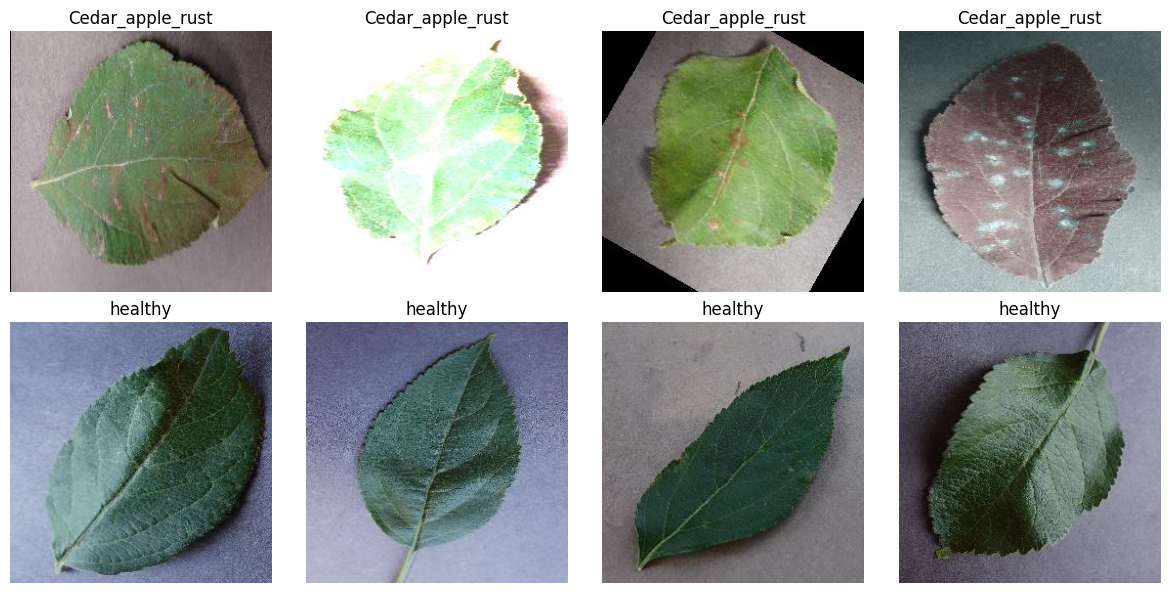

In [ ]:
# Función para mostrar imágenes aleatorias de cada clase
def mostrar_imagenes_aleatorias(directorio, clases, cantidad=4):
    plt.figure(figsize=(12, 6))
    for i, clase in enumerate(clases):
        clase_path = Path(directorio) / clase
        imagenes = list(clase_path.glob("*.JPG"))
        seleccionadas = random.sample(imagenes, cantidad)

        for j, img_path in enumerate(seleccionadas):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(clases), cantidad, i * cantidad + j + 1)
            plt.imshow(img)
            plt.title(clase.replace("Apple___", ""))
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizamos 4 imágenes aleatorias por clase desde la carpeta de entrenamiento
mostrar_imagenes_aleatorias("data/train", ["Apple___Cedar_apple_rust", "Apple___healthy"], cantidad=4)

**Transformaciones Geométricas y Data Augmentation:**

Uso de rotaciones, escalados, traslaciones o correcciones geométricas para aumentar el dataset o alinear imágenes.

In [ ]:
!pip install -q albumentations==1.4.3 opencv-python-headless

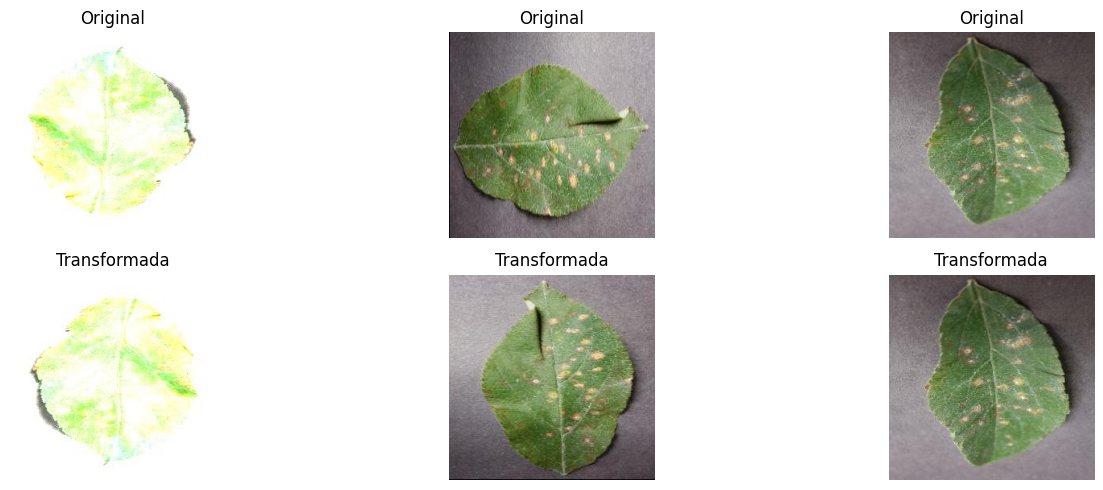

In [ ]:
# Definimos transformaciones de data augmentation
augmentacion = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
])

# Función para aplicar augmentations a imágenes desde una carpeta
def visualizar_augmentaciones(ruta, cantidad=3):
    imagenes = list(Path(ruta).glob("*.JPG"))
    imagenes = random.sample(imagenes, min(len(imagenes), cantidad))

    plt.figure(figsize=(15, 5))
    for idx, img_path in enumerate(imagenes):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        aug_img = augmentacion(image=img)['image']

        plt.subplot(2, cantidad, idx + 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(2, cantidad, idx + 1 + cantidad)
        plt.imshow(aug_img)
        plt.title("Transformada")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualizamos augmentations en una clase
visualizar_augmentaciones("data/train/Apple___Cedar_apple_rust", cantidad=3)


**Filtrado y Convolución:**

Aplicar filtros de suavizado o filtros de borde (Prewitt, Sobel) para resaltar características.

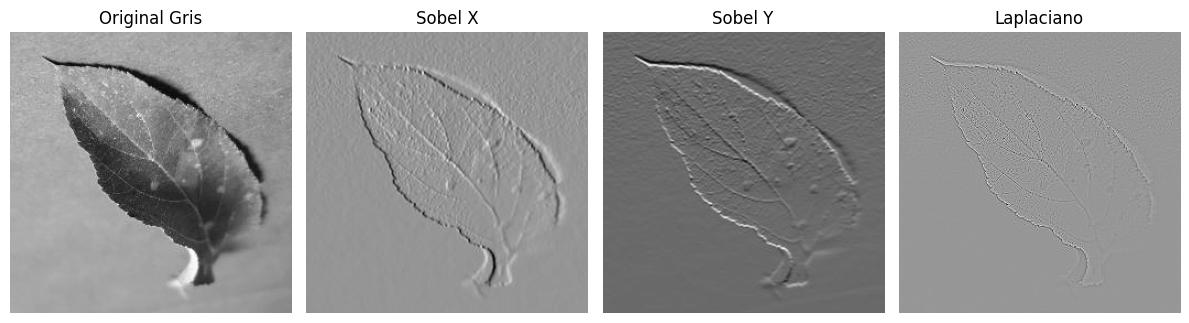

In [ ]:
def aplicar_filtros(img_path):
    img = cv2.imread(str(img_path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Filtro Sobel
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = cv2.magnitude(sobelx, sobely)

    # Filtro Laplaciano
    laplacian = cv2.Laplacian(img_gray, cv2.CV_64F)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Original Gris")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(sobelx, cmap='gray')
    plt.title("Sobel X")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(sobely, cmap='gray')
    plt.title("Sobel Y")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(laplacian, cmap='gray')
    plt.title("Laplaciano")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Probar con una imagen de ejemplo
ejemplo = list((Path("data/train/Apple___Cedar_apple_rust")).glob("*.JPG"))[0]
aplicar_filtros(ejemplo)

**Detección de bordes y umbralización (Canny y Otsu):**

Implementación de Canny, Laplacian, Otsu, etc.

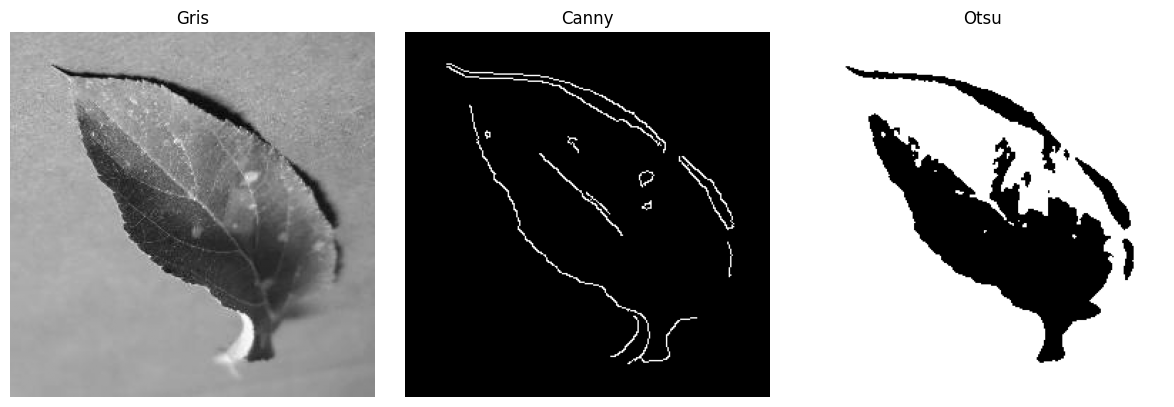

In [ ]:
def deteccion_bordes_umbral(img_path):
    img = cv2.imread(str(img_path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # Canny
    canny = cv2.Canny(img_blur, 100, 200)

    # Otsu
    _, otsu = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Mostrar resultados
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Gris")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(canny, cmap='gray')
    plt.title("Canny")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(otsu, cmap='gray')
    plt.title("Otsu")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Probar con una imagen de ejemplo
deteccion_bordes_umbral(ejemplo)

**Ecualización de Histogramas:**

Mejorar la iluminación de las imágenes antes de extraer características o entrenar modelos

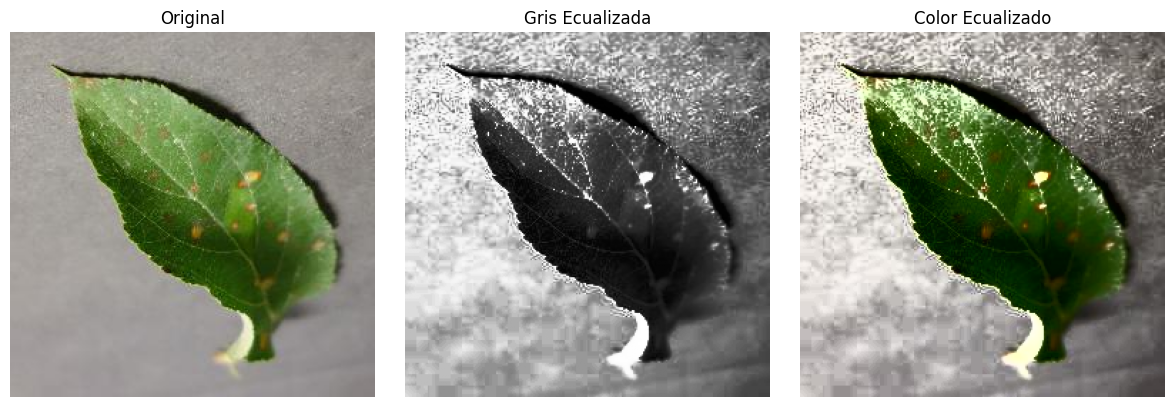

In [ ]:
def ecualizar_histograma(img_path):
    img = cv2.imread(str(img_path))

    # Imagen en escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq_gray = cv2.equalizeHist(img_gray)

    # Imagen a color (ecualización en el canal Y)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    eq_color = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)

    # Mostrar resultados
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(eq_gray, cmap='gray')
    plt.title("Gris Ecualizada")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(eq_color, cv2.COLOR_BGR2RGB))
    plt.title("Color Ecualizado")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Probar con una imagen de ejemplo
ecualizar_histograma(ejemplo)

**Feature Detection y Descriptores (SIFT, SURF):**

Extracción de puntos clave para clasificadores

In [ ]:
!pip install opencv-contrib-python --quiet

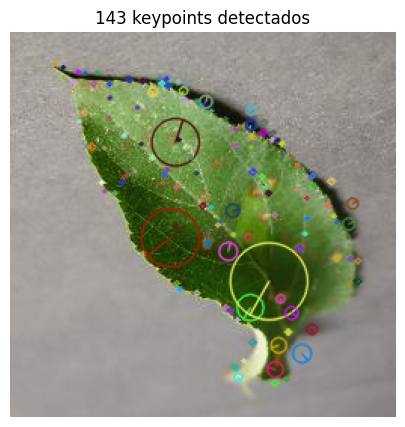

In [ ]:
def aplicar_sift(img_path):
    img = cv2.imread(str(img_path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    # Dibujar keypoints
    img_kp = cv2.drawKeypoints(img, keypoints, None,
                               flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Mostrar resultados
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.title(f"{len(keypoints)} keypoints detectados")
    plt.axis("off")
    plt.show()

    return keypoints, descriptors

# Probar con una imagen de ejemplo
kp, desc = aplicar_sift(ejemplo)

**Machine Learning Pipeline en Scikit-Learn:**

Construcción de un pipeline modular:

▪ Transformaciones de datos

▪ Selección de características

▪ Entrenamiento de clasificador (SVM, Random Forest, etc.) o Segmentación no
supervisada (k-means, GMM, etc.).

▪ Evaluación y Métricas.

In [ ]:
# Función: Extraer descriptores SIFT de cada imagen
def extraer_sift_dataset(carpeta):
    rutas = list(Path(carpeta).rglob("*.jpg")) + list(Path(carpeta).rglob("*.JPG"))
    etiquetas = []
    descriptores = []

    sift = cv2.SIFT_create()

    for ruta in rutas:
        img = cv2.imread(str(ruta))
        if img is None:
            continue
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, desc = sift.detectAndCompute(img_gray, None)

        if desc is not None:
            descriptores.append(desc)
            etiquetas.append(ruta.parent.name)

    return descriptores, etiquetas

# Extraer descriptores de entrenamiento y prueba
desc_train, y_train = extraer_sift_dataset("data/train")
desc_test, y_test = extraer_sift_dataset("data/test")

print(f"Imágenes procesadas - Train: {len(desc_train)} / Test: {len(desc_test)}")

# Agrupar todos los descriptores para construir el vocabulario
desc_all = np.vstack(desc_train)
k = 50  # número de palabras visuales

# Entrenar el vocabulario visual con KMeans
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
kmeans.fit(desc_all)

# Convertir descriptores a histogramas BoVW
def construir_histogramas(descriptores, modelo_kmeans, k):
    histograms = []

    for desc in descriptores:
        predicciones = modelo_kmeans.predict(desc)
        hist, _ = np.histogram(predicciones, bins=np.arange(k + 1))
        histograms.append(hist)

    return np.array(histograms)

X_train = construir_histogramas(desc_train, kmeans, k)
X_test = construir_histogramas(desc_test, kmeans, k)

print(f"✅ X_train shape: {X_train.shape}, y_train: {len(y_train)}")
print(f"✅ X_test shape: {X_test.shape}, y_test: {len(y_test)}")


Imágenes procesadas - Train: 3621 / Test: 1361
✅ X_train shape: (3621, 50), y_train: 3621
✅ X_test shape: (1361, 50), y_test: 1361


Reporte de Clasificación:
                          precision    recall  f1-score   support

Apple___Cedar_apple_rust       0.97      0.97      0.97       631
         Apple___healthy       0.97      0.97      0.97       730

                accuracy                           0.97      1361
               macro avg       0.97      0.97      0.97      1361
            weighted avg       0.97      0.97      0.97      1361



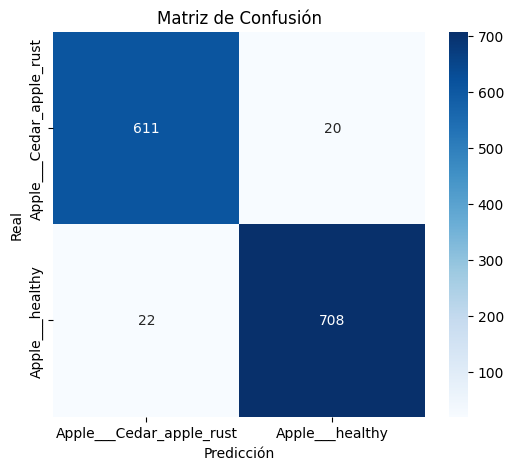

In [ ]:
# Creamos el pipeline: escalado + SVM
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", random_state=42))
])

# Entrenamiento
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


**Optimización de Hiperparámetros:**

Uso de Grid Search o Random Search con
Pipeline de sklearn.

In [ ]:
# Pipeline con SVM
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Definimos el grid de búsqueda
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# GridSearch con validación cruzada
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Resultados
print("✅ Mejor combinación de parámetros:")
print(grid.best_params_)

print("\n🔍 Mejor precisión en validación cruzada:")
print(f"{grid.best_score_:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Mejor combinación de parámetros:
{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

🔍 Mejor precisión en validación cruzada:
0.9735



📊 Reporte en conjunto de prueba:
                          precision    recall  f1-score   support

Apple___Cedar_apple_rust       1.00      1.00      1.00       631
         Apple___healthy       1.00      1.00      1.00       730

                accuracy                           1.00      1361
               macro avg       1.00      1.00      1.00      1361
            weighted avg       1.00      1.00      1.00      1361



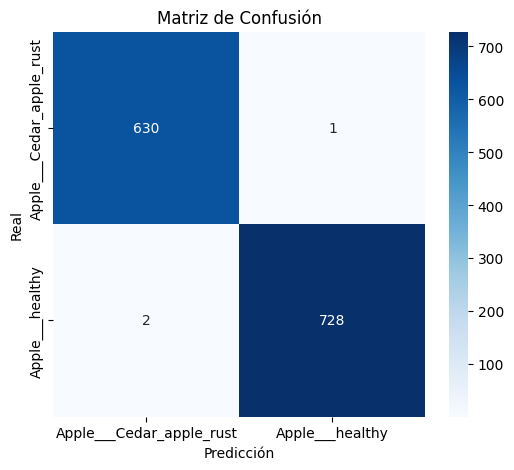

In [ ]:
# Predicción en test con el mejor modelo
y_pred = grid.best_estimator_.predict(X_test)

# Reporte de clasificación
print("\n📊 Reporte en conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


**Prueba del modelo de clasificación:**

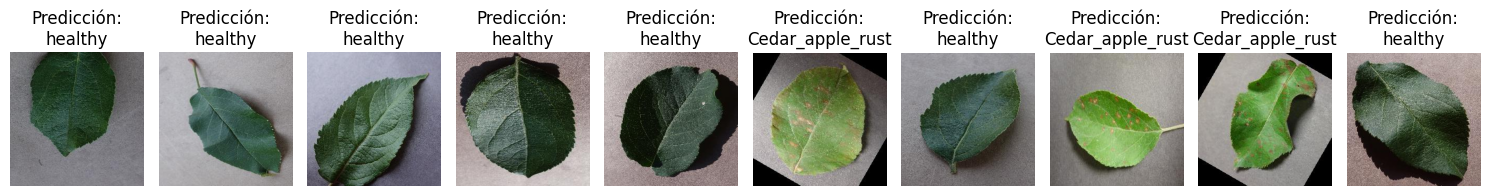

In [ ]:
def predecir_imagenes_aleatorias(ruta_base, modelo, kmeans, k=50, cantidad=5):
    rutas = list(Path(ruta_base).rglob("*.jpg")) + list(Path(ruta_base).rglob("*.JPG"))
    muestras = random.sample(rutas, cantidad)

    sift = cv2.SIFT_create()

    plt.figure(figsize=(15, 4))

    for i, img_path in enumerate(muestras):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        kp, desc = sift.detectAndCompute(img_gray, None)

        if desc is not None:
            pred = kmeans.predict(desc)
            hist, _ = np.histogram(pred, bins=np.arange(k + 1))
            hist = hist.reshape(1, -1)
            resultado = modelo.predict(hist)[0]
        else:
            resultado = "Sin descriptores"

        # Mostrar imagen y predicción
        plt.subplot(1, cantidad, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Predicción:\n{resultado.replace('Apple___', '')}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Usamos el mejor modelo encontrado en GridSearch
predecir_imagenes_aleatorias("data/test", grid.best_estimator_, kmeans, k=50, cantidad=10)